# `TODO`

> Additional things to do.

``` HTML
1. Annotate MNE object based on number of targets tracked
2. Annotate MNE object with probe locations
3. Automate wavelength selection based on absorption spectra of hemoglobin
```

---

# Imports

In [1]:
# Additional inbuilt utilities
from itertools import chain, compress

In [2]:
# Regex
import re

---

In [3]:
# Array
import numpy as np

In [4]:
# Table
import pandas as pd

---

In [5]:
# Plotting
import matplotlib.pyplot as plt

---

In [6]:
# Statistics
import statsmodels.api as sm

---

In [7]:
# fNIRS
import mne

---

In [8]:
# Custom (misc)
import utils

## Config

# Load Data

In [9]:
# Number of hemispheres from which data is collected
N_HEMISPHERES = 1

## ~~RAW.FIF Data~~

In [10]:
# Read '.raw.fif' file
raw_fif = mne.io.read_raw_fif('data/ETH/Front_3Modules/FrontHeadData.raw.fif', preload=True)
raw_fif.crop(tmin=120) # Delete first 60s for this dataset (idle data)

Opening raw data file data/ETH/Front_3Modules/FrontHeadData.raw.fif...
Isotrak not found
    Range : 0 ... 7519 =      0.000 ...   751.900 secs
Ready.
Reading 0 ... 7519  =      0.000 ...   751.900 secs...


<Raw | FrontHeadData.raw.fif, 36 x 6320 (631.9 s), ~1.8 MB, data loaded>

### Data Specific Constants

In [11]:
# Wavelengths to consider (can choose two -- limitation of MNE, see issue https://github.com/mne-tools/mne-python/issues/9816)
WAVELENGTHS_PICKED = [774, 865]

In [12]:
# Add WAVELENGTHS_PICKED to MNE Raw Object
raw_fif._WAVELENGTHS_PICKED = WAVELENGTHS_PICKED

---

---

---

## CSV Data

In [13]:
# Read CSV data as Pandas DataFrame
data_pd = pd.read_csv('data/Data_experiment_4_RightLateral_conversion.csv')

In [14]:
data_pd.head(20) # 147540 rows => 147540/12 = 12295 readings

,Time[ms],Channel,BL,855[nm],770[nm],810[nm],885[nm]
0,3481.0,0.0,0.028794,0.495354,1.081621,0.862669,0.731243
1,3481.0,1.0,0.028199,0.804807,1.150561,0.890272,0.661158
2,3481.0,2.0,0.029389,0.633143,0.945846,1.069764,0.818402
3,3481.0,3.0,0.026368,1.442985,0.918929,1.299977,2.390890
4,3481.0,4.0,0.208240,0.645960,0.834836,1.015473,0.580774
5,3481.0,5.0,0.253925,0.674662,0.888899,0.999908,0.567910
6,3481.0,6.0,0.217990,0.581369,0.933532,1.018860,0.446372
7,3481.0,7.0,0.027192,1.276631,1.328176,1.312566,2.062028
8,3481.0,8.0,0.274205,0.662165,0.777981,1.049210,0.627558
9,3481.0,9.0,0.221103,0.763424,0.772763,1.043671,0.569604


### Data Specific Constants

In [15]:
# Wavelengths to consider (can choose two -- limitation of MNE, see issue https://github.com/mne-tools/mne-python/issues/9816)
WAVELENGTHS_PICKED = [855, 770]

In [16]:
# Unused Channels
CH_UNUSED = {3, 7, 11}

---

In [17]:
# Wavelengths availables (automatic extraction)
WAVELENGTHS = [int(match.groups()[0]) for column in data_pd.columns if (match := re.compile(r'(\d+)\[nm\]').match(column))] # [855, 770, 810, 885]

In [18]:
# Total number of wavelengths
N_WAVELENGTHS_T = len(WAVELENGTHS)

In [19]:
# Number of wavelengths used in analysis
N_WAVELENGTHS = len(WAVELENGTHS_PICKED) # 2

In [20]:
# Number of probes
N_PROBES = 3 # Per Hemisphere

In [21]:
# Number of expected channels
N_CHANNELS = N_PROBES**2  # *N_WAVELENGTHS_T Per Hemisphere

---

In [22]:
# Source-Detector pairs (all)
S_D = ['S44_D44', 'S39_D39', 'S43_D43', 'S44_D44', 'S44_D39', 'S44_D43', 'S39_D44', 'S39_D39', 'S39_D43', 'S43_D44', 'S43_D39', 'S43_D43'] # Decimal
# ['S2C_D2C', 'S27_D27', 'S2B_D2B', 'S2C_D2C', 'S2C_D27', 'S2C_D2B', 'S27_D2C', 'S27_D27', 'S27_D2B', 'S2B_D2C', 'S2B_D27', 'S2B_D2B'] # Hexadecimal

In [23]:
# Dictionary (map) of channel number to channel name
CH_MAP = dict(zip(map(int, data_pd['Channel'].unique()), S_D))
print(CH_MAP)

{0: 'S44_D44', 1: 'S39_D39', 2: 'S43_D43', 3: 'S44_D44', 4: 'S44_D39', 5: 'S44_D43', 6: 'S39_D44', 7: 'S39_D39', 8: 'S39_D43', 9: 'S43_D44', 10: 'S43_D39', 11: 'S43_D43'}


In [24]:
# Short Channels
CH_SHORT = set(utils.find_short_channels(S_D)[1]) - CH_UNUSED

In [25]:
# Long Channels
CH_LONG = set(utils.find_long_channels(S_D)[1]) - CH_UNUSED

In [26]:
# Used Channels
CH_USED = CH_SHORT.union(CH_LONG)

---

In [27]:
# Names of the wavelength specific channels (only used channels)
CH_NAMES = [f'{CH_MAP[ch]} {wavelength}'
            for ch in list(CH_MAP.keys()) if ch not in CH_UNUSED # product(range(N_PROBES), repeat=2)
            for wavelength in WAVELENGTHS]
print(CH_NAMES) # (12 total - 3 unused) * 4 wavelengths = 36

['S44_D44 855', 'S44_D44 770', 'S44_D44 810', 'S44_D44 885', 'S39_D39 855', 'S39_D39 770', 'S39_D39 810', 'S39_D39 885', 'S43_D43 855', 'S43_D43 770', 'S43_D43 810', 'S43_D43 885', 'S44_D39 855', 'S44_D39 770', 'S44_D39 810', 'S44_D39 885', 'S44_D43 855', 'S44_D43 770', 'S44_D43 810', 'S44_D43 885', 'S39_D44 855', 'S39_D44 770', 'S39_D44 810', 'S39_D44 885', 'S39_D43 855', 'S39_D43 770', 'S39_D43 810', 'S39_D43 885', 'S43_D44 855', 'S43_D44 770', 'S43_D44 810', 'S43_D44 885', 'S43_D39 855', 'S43_D39 770', 'S43_D39 810', 'S43_D39 885']


In [28]:
# Type of channels -- Raw fNIRS Continuous Wave Amplitude
# https://mne.tools/stable/glossary.html#term-data-channels
CH_TYPES = 'fnirs_cw_amplitude' # [] * N_CHANNELS * N_WAVELENGTHS_T * N_HEMISPHERES

In [29]:
# Sampling frequency (based on difference between timestamps in consecutive readings ~54ms)
F_S = 1000/np.ptp(data_pd['Time[ms]'])*(len(data_pd) - len(S_D))/len(S_D) # 1000/54.319 ~ 18.41 Hz

---

In [30]:
# Remove unused channels and create a new DataFrame
data_pd_ = data_pd.loc[data_pd['Channel'].isin(CH_USED)]

In [31]:
# Check if the number of channels are as expected (they must not be more than `N_CHANNELS`)
if len(data_pd_['Channel'].unique()) != N_CHANNELS:
    print(f'Unexpected number of channels. Expected - {N_CHANNELS}; Received - {len(data_pd_["Channel"].unique())}')

In [32]:
# Timestamps (for used channels only)
tms = data_pd_['Time[ms]']

# Backlight intesities (for used channels only)
bkl = data_pd_['BL']

### Backlight Removal

In [33]:
# Fit 3rd-order polynomial to backlight data
rlm_results = sm.RLM(bkl, np.c_[np.ones_like(bkl), # Constant
                                (t1 := np.arange(len(data_pd))[data_pd['Channel'].isin(CH_USED)]), t1**2, t1**3, # Timestamp (^1, ^2, ^3) with consideration to time spent recording unused channels
                                # (t2 := np.arange(len(bkl))), t2**2, t2**3 # Timestamp (^1, ^2, ^3) without consideration to time spent recording unused channels
                               ]).fit()

In [34]:
# Subtract predicted backlight signal from raw data of all wavelengths and remove other columns ('Time[ms]', 'BL', and 'Channel')
data_pd_ = data_pd_[data_pd.columns[-N_WAVELENGTHS_T:]] - np.tile(rlm_results.fittedvalues, (N_WAVELENGTHS_T, 1)).T

In [35]:
# DataFrame with backlight-removed signal intensities (the rows are chunked in groups of `N_CHANNELS` (number of used channels),
# i.e. first 9 rows = recoding 1; second 9 rows = recording 2; ...)
data_pd_.head(10)

,855[nm],770[nm],810[nm],885[nm]
0,0.495354,1.081621,0.862669,0.731243
1,0.804794,1.150548,0.890260,0.661146
2,0.633118,0.945821,1.069739,0.818377
4,0.645910,0.834787,1.015423,0.580724
5,0.674600,0.888837,0.999846,0.567848
6,0.581294,0.933457,1.018785,0.446297
8,0.662066,0.777882,1.049111,0.627458
9,0.763312,0.772651,1.043559,0.569492
10,0.681267,0.754419,1.043501,0.555746
12,0.495204,1.080922,0.863618,0.731643


### MNE Object

In [36]:
# Create Numpy Array from the corrected DataFrame and reshape it to have rows corresponding to time-Warying signal for each channel and wavelength combination
# 36 rows; each corresponding in order to `CH_NAMES`
data_np_ = np.array(data_pd_).reshape(-1, N_CHANNELS * N_WAVELENGTHS_T).T

In [37]:
# Create MNE.Info Object
info_csv = mne.create_info(ch_names=CH_NAMES, sfreq=F_S, ch_types=CH_TYPES)

`Manually update info object parameters for location`
> Manual modification is not recommended, but there doesn't seem to any other option as there are no inbuilt functions for this  
> https://github.com/mne-tools/mne-python/blob/main/mne/io/meas_info.py#L2425
>> Info: `chs['loc']` is an array of channel 'location' of length 12

In [38]:
for chs in info_csv['chs']:
    # For fNIRS, the 10th element corresponds to the wavelength
    # https://github.com/mne-tools/mne-python/blob/main/mne/preprocessing/nirs/nirs.py#L150
    chs['loc'][9] = float(chs['ch_name'].split()[1])

In [39]:
for chs in info_csv['chs']:
    # For fNIRS, the 12th element is some number that depends on whether the channel is short (0.007) or long (0.03)
    # TODO: find significance of this number
    # > No specific reference to this 11th index found in the MNE-Python source code
    # >> Only references to range of values ('[:]' or '[3:]') in device-spcific functions with no apparent applicability to the context here
    chs['loc'][11] = 0.007 if utils.is_short_channel(chs['ch_name']) else 0.03

In [40]:
# Copy other meta data from sample *fif* file
info_csv['device_info'] = raw_fif.info['device_info'] # {'type': 'fNIRS-CW', 'model': 'optoHIVE'}
info_csv['experimenter'] = raw_fif.info['experimenter'] # 'optoHIVE Team'
# meas_date # datetime.datetime(2022, 12, 16, 14, 36, 20, 620708, tzinfo=datetime.timezone.utc)
# file_id (== meas_id)
# meas_id (== file_id)

In [41]:
raw_fif.info['meas_date']

datetime.datetime(2022, 12, 16, 14, 36, 20, 620708, tzinfo=datetime.timezone.utc)

---

In [42]:
# Create MNE.IO.Raw Object
raw_csv = mne.io.RawArray(data_np_, info_csv)

Creating RawArray with float64 data, n_channels=36, n_times=12295
    Range : 0 ... 12294 =      0.000 ...   667.803 secs
Ready.


In [43]:
# Add WAVELENGTHS_PICKED to MNE Raw Object
raw_csv._WAVELENGTHS_PICKED = WAVELENGTHS_PICKED

# Pre-Processing

In [44]:
# Set a MNE object variable that is used for all subsequent analysis
# This is done so that different data can be analysed simply by reassigning this variable and re-running the cells below

raw_intensity = raw_csv.copy()
# raw_intensity = raw_fif.copy()

### Initial Plots

Effective window size : 13.906 (s)


/tmp/ipykernel_127754/3425571121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_intensity.compute_psd().plot();


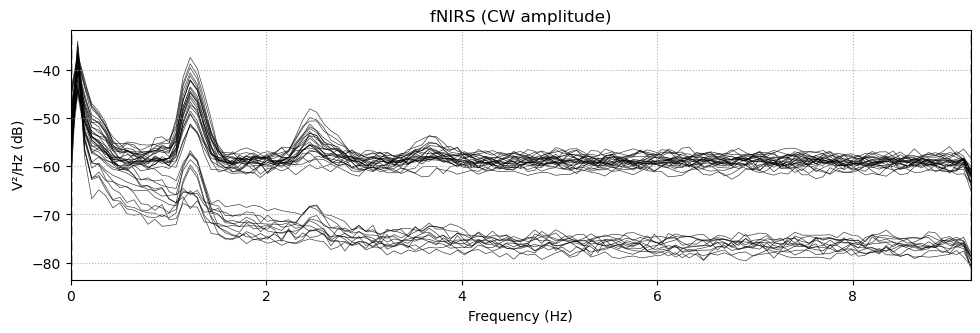

In [45]:
raw_intensity.compute_psd().plot();

Using matplotlib as 2D backend.


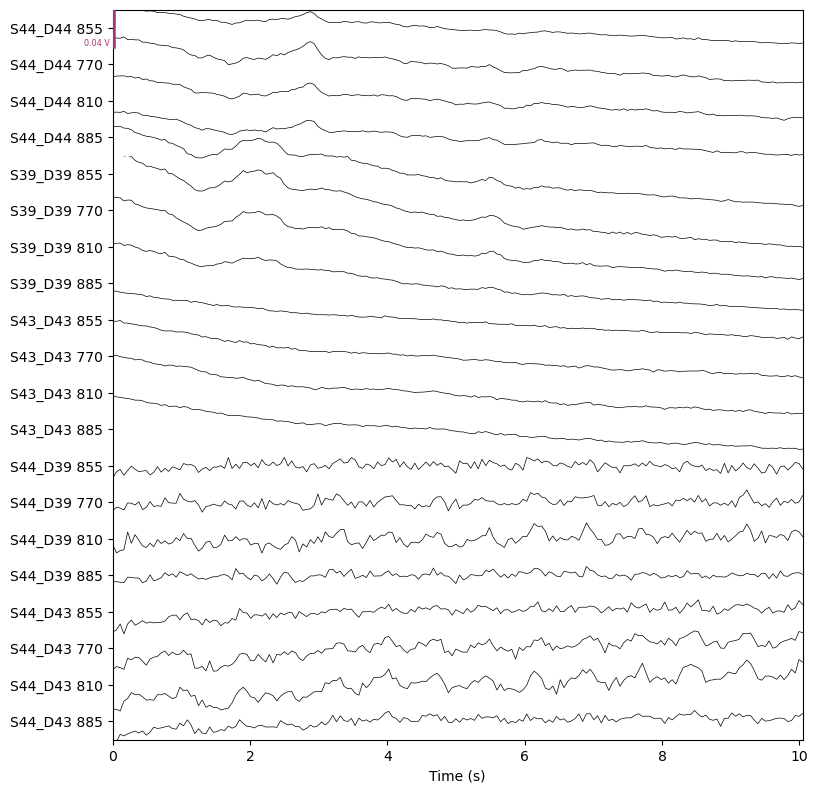

In [46]:
# %matplotlib widget
raw_intensity.plot(show_scrollbars=False);

### Pick Long Channels

In [47]:
# Pick long channels (for every wavelength)
raw_intensity.pick([ch for ch in utils.find_long_channels(raw_intensity.ch_names)[0] if int(ch.split()[1]) in raw_intensity._WAVELENGTHS_PICKED])

<RawArray | 12 x 12295 (667.8 s), ~1.1 MB, data loaded>

### Remove Instrument Drift and Noise

### Raw -> Optical Densities

> https://github.com/mne-tools/mne-python/blob/main/mne/preprocessing/nirs/_optical_density.py

In [48]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

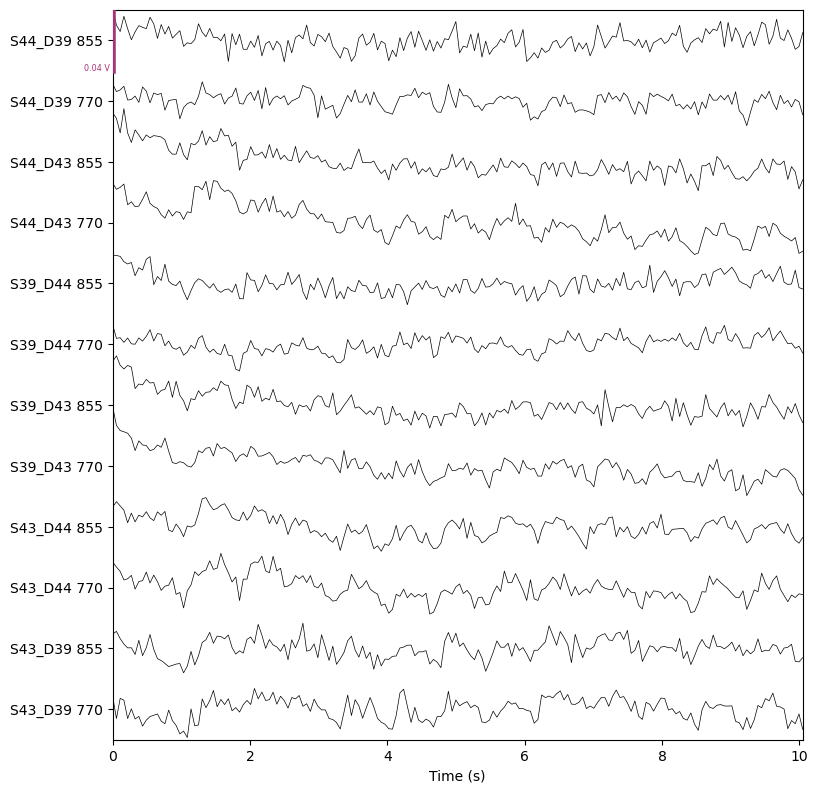

In [49]:
raw_od.plot(show_scrollbars=False);

### Motion Artifact Removal

> TDDR

In [50]:
corrected_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od)

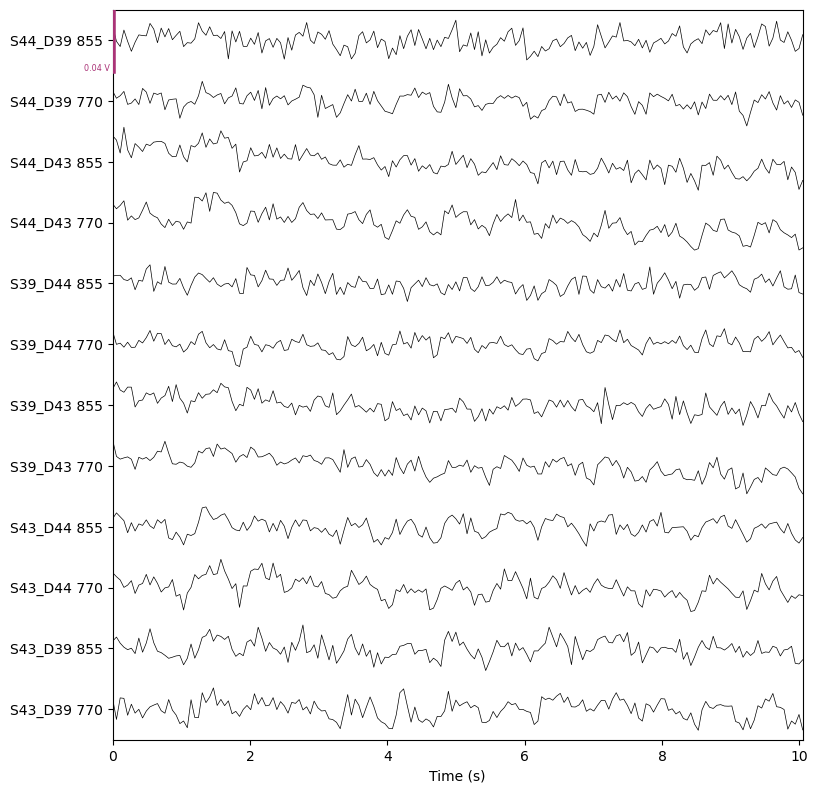

In [51]:
corrected_od.plot(show_scrollbars=False);

### Optical Densities -> HbO and HbR concentrations

> MBBL

### Filtering

> Notch Filtering  
>> 

### Channel Selection

> Manual  
> Automatic -- Heart Rate Based  
> Automatic -- RMS Threshold Based

# MAIN

## GLM

> Short-Channel Regression

## Statistics